In [1]:
import folium
import geopandas as gpd
import pandas as pd
import numpy as np
import os, json, re 
import matplotlib.pyplot as plt
import requests
from folium.plugins import MarkerCluster
from bs4 import BeautifulSoup

%matplotlib inline
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# load_data
weekend, holiday = [], []
path = r'C:\Users\EonKim\Desktop\git_upload\khu\subway traffic\dataset'
def load_data(path):
    weekend, holiday = [], []
    os.chdir(path)

    folders = os.listdir()
    for folder in folders:
        _, day = folder.split('-')
        df = pd.read_csv(folder + '\\' + day + r'_시간대별 열차인원(1시간 단위).csv', encoding = 'euc-kr')
        if int(day[-2:]) % 7 in [4,5]:
            holiday.append(df)
        elif day[-2:] in ['05','06']:
            holiday.append(df)

        else:
            weekend.append(df)

    return weekend, holiday
    
weekend, holiday = load_data(path)

In [3]:
def target():
    station_path = r'C:\Users\EonKim\Desktop\git_upload\khu\subway traffic\location'
    os.chdir(station_path)
    station_col = pd.read_csv('station_coordinate.csv', encoding = 'utf-8', index_col=0)

    station_col = station_col.iloc[:,0].apply(lambda x: x.split('(')[0])
    station_col = station_col[~station_col.duplicated(keep = 'first')].reset_index(drop = True).tolist()
    for i in ['미아사거리', '동대문역사문화공원5', '올림픽공원', '이수'] : station_col.remove(i)
    station_col.extend(['미아삼거리', '동대문역사문화공원'])
    return station_col

In [4]:
def target():
    station_path = r'C:\Users\EonKim\Desktop\git_upload\khu\subway traffic\location'
    os.chdir(station_path)
    station_col = pd.read_csv('loc.csv', encoding = 'utf-8', index_col = 0)

    station_col = station_col.iloc[:,2].apply(lambda x: x.split('(')[0])
    station_col = station_col[~station_col.duplicated(keep = 'first')].reset_index(drop = True).tolist()
    for i in ['미아사거리', '동대문역사문화공원5', '올림픽공원', '이수'] : station_col.remove(i)
    station_col.extend(['미아삼거리', '동대문역사문화공원'])
    return station_col

In [5]:
target()

['서울역',
 '시청',
 '종각',
 '종로3가',
 '종로5가',
 '동대문',
 '신설동',
 '제기동',
 '청량리',
 '동묘앞',
 '을지로입구',
 '을지로3가',
 '을지로4가',
 '동대문역사문화공원',
 '신당',
 '상왕십리',
 '왕십리',
 '한양대',
 '뚝섬',
 '성수',
 '건대입구',
 '구의',
 '강변',
 '잠실나루',
 '잠실',
 '신천',
 '종합운동장',
 '삼성',
 '선릉',
 '역삼',
 '강남',
 '교대',
 '서초',
 '방배',
 '사당',
 '낙성대',
 '서울대입구',
 '봉천',
 '신림',
 '신대방',
 '구로디지털단지',
 '대림',
 '신도림',
 '문래',
 '영등포구청',
 '당산',
 '합정',
 '홍대입구',
 '신촌',
 '이대',
 '아현',
 '충정로',
 '용답',
 '신답',
 '도림천',
 '양천구청',
 '신정네거리',
 '용두',
 '지축',
 '구파발',
 '연신내',
 '불광',
 '녹번',
 '홍제',
 '무악재',
 '독립문',
 '경복궁',
 '안국',
 '동대입구',
 '약수',
 '금호',
 '옥수',
 '압구정',
 '신사',
 '잠원',
 '고속터미널',
 '남부터미널',
 '양재',
 '매봉',
 '도곡',
 '대치',
 '학여울',
 '대청',
 '일원',
 '수서',
 '가락시장',
 '경찰병원',
 '오금',
 '당고개',
 '상계',
 '노원',
 '창동',
 '쌍문',
 '수유',
 '미아',
 '길음',
 '성신여대입구',
 '한성대입구',
 '혜화',
 '충무로',
 '명동',
 '회현',
 '숙대입구',
 '삼각지',
 '신용산',
 '이촌',
 '동작',
 '총신대입구',
 '남태령',
 '방화',
 '개화산',
 '김포공항',
 '송정',
 '마곡',
 '발산',
 '우장산',
 '화곡',
 '까치산',
 '신정',
 '목동',
 '오목교',
 '양평',
 '영등포시장',
 '신길',
 '여의도',
 '여의나루',
 '마포',
 '공

In [6]:
def preprocessing(day, loc_path = None, type = 'board'):
    output = []
    for df in day:
        trans = df.copy()
        trans['역명'] = trans['역명'].str.replace('E', '')

        if type == 'alight':
            trans = df[df['구분'] == '하차인원'].groupby('역명').sum().iloc[:,4:-3]
            
            output.append(trans)
        
        else:
            trans = df[df['구분'] == '승차인원'].groupby('역명').sum().iloc[:,4:-3]
            output.append(trans)
    out = output[0]
    for idx in output[1:]:
        out += idx
    out /= len(output) 
    out = out.apply(lambda x: round(x,2))
    out.columns = np.arange(5, 25)
    out.index.name = None
    out = out.loc[target(),:]


    loc_path = r'C:\Users\EonKim\Desktop\git_upload\khu\subway traffic\location'
    os.chdir(loc_path)
    loc_file = r'station_coordinate.csv'
    location = pd.read_csv(loc_file, encoding = 'utf-8')
    col_name = location['name']
    loc = location.iloc[:,[ -2,-1]].copy()
    loc.index = col_name
    loc = loc[~loc.duplicated(keep='first')]

    out = pd.merge(out, loc, left_index=True, right_index = True)

    return out


In [7]:
week_board = preprocessing(weekend)
week_alight = preprocessing(weekend, type = 'alight')

holi_board = preprocessing(holiday)
holi_alight = preprocessing(holiday, type = 'alight')

In [8]:
week_board

,5,6,7,8,9,10,11,12,13,14,...,17,18,19,20,21,22,23,24,lat,lng
가락시장,315.36,1144.23,3183.59,5485.59,3159.14,2208.09,1955.05,2113.55,2201.59,2119.00,...,3266.82,5580.00,2954.41,2053.64,1763.36,1672.36,798.45,165.27,37.492522,127.118234
가산디지털단지,1337.27,3404.82,7540.86,12918.09,8167.64,4959.73,5359.18,4910.55,5565.27,5355.82,...,13584.27,28891.55,16705.18,8786.73,7530.41,5702.41,2887.18,757.45,37.481072,126.882343
강남,567.00,2709.00,7510.55,13894.41,9796.86,6324.55,6101.59,6558.73,7567.36,8228.18,...,14953.64,27228.27,18428.50,12999.50,13632.86,15034.86,7006.41,1884.41,37.497175,127.027926
강남구청,235.36,1600.09,4211.45,9030.09,6319.77,3129.82,2860.59,2683.59,3225.45,3059.86,...,6190.55,12052.95,7997.09,4659.77,4220.45,3704.05,1602.95,314.68,37.517186,127.041280
강동,864.36,4300.77,13789.64,15743.91,7131.14,4700.59,4090.86,4202.27,4323.59,3906.00,...,7946.82,10228.77,5980.91,3754.50,3474.00,4265.45,2366.82,769.23,37.535804,127.132481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
홍제,306.00,905.86,2807.77,3553.41,1977.86,1179.32,1090.95,1064.91,955.05,940.64,...,1285.32,1373.23,736.55,560.73,498.59,368.73,194.27,42.27,37.589066,126.943736
화곡,872.14,1953.45,5009.18,6974.41,3013.09,1691.05,1460.59,1414.86,1308.36,1159.50,...,1361.36,1581.73,1011.50,671.09,586.68,515.27,252.27,58.95,37.541513,126.840461
화랑대,221.95,720.59,2523.00,2707.59,1267.73,642.09,604.73,555.64,561.55,453.59,...,842.45,803.50,368.64,297.32,203.91,173.18,94.45,19.05,37.620064,127.084689
회현,72.91,170.09,258.41,387.64,566.41,811.41,1268.36,1664.32,2338.36,2790.41,...,5085.82,5661.95,2819.45,2376.27,1162.05,756.59,321.59,56.64,37.558514,126.978246


week graph

In [9]:
url = 'https://raw.githubusercontent.com/suanlab/dataset/master/'
seoul_geo = f'{url}/seoul_municipalities_geo_simple.json'


In [10]:
gu_subway = pd.DataFrame( 
    {'name' : [
        '강남구', '중구', '송파구', '마포구', '강서구', '영등포구', '서초구',
        '성동구', '용산구', '노원구', '동작구', '은평구', '종로구', '구로구', '중랑구',
        '강동구', '동대문구', '광진구', '성북구', '도봉구', '서대문구', '양천구', '관악구', '금천구', '강북구'],
    'number' : [24, 14, 18, 15, 17, 15, 15, 15, 12, 13, 12, 12, 11, 10, 10, 10, 8, 9, 9, 6, 6, 6, 4, 4, 3]})

trans_line2 = [
    '가락시장', '가산디지털단지', '강남', '강남구청', '건대입구', '검암', '계양', 
    '광운대', '고잔', '교대', '군자', '금정', '기흥', '까치산', '노량진', '노원',
    '신길온천', '당산', '대곡', '대림', '도곡', '도봉산', '동대문', '동묘앞', '동작', 
    '마곡나루','망우', '모란', '미금', '보문', '복정', '부평', '부평구청', '불광', 
    '사당', '삼각지', '석계', '석남', '석촌', '선릉', '선정릉', '성신여대입구', '소사', '수서',
    '수원', '시청', '신길', '신내', '신당', '신도림', '안산', '약수', '양재', '여의도', '연신내', '영등포구청',
    '오이도', '오금', '옥수', '온수', '올림픽공원', '용산', '용유', '을지로3가', '을지로4가', '이매', '총신대입구',
    '이촌', '잠실', '종합운동장', '주안', '중랑', '중앙', '창동', '천호', '청구', '충무로', '충정로', '태릉입구',
    '판교', '합정', '효창공원앞']

trans_line3 = [
    '고속터미널', '동대문역사문화공원', '디지털미디어시티', '상봉', '종로3가', '초지', '홍대입구', '회기'
]
trans_line4 = [
    '공덕', '김포공항', '왕십리', '청량리'
]



In [11]:
line, line2, line3, line4 = [], [], [], []
for idx in week_board.index:
    if idx in trans_line2:
        line2.append(idx)
    elif idx in trans_line3:
        line3.append(idx)
    elif idx in trans_line4:
        line4.append(idx)
    else:
        line.append(idx)


In [12]:
week_board.to_csv('week_board.csv')
holi_board.to_csv('holi_board.csv')
week_alight.to_csv('week_alight.csv')
holi_alight.to_csv('holi_alight.csv')
# line.to_csv('transfer_1.csv')
# line2.to_csv('transfer_2.csv')
# line3.to_csv('transfer_3.csv')
# line4.to_csv('transfer_4.csv')

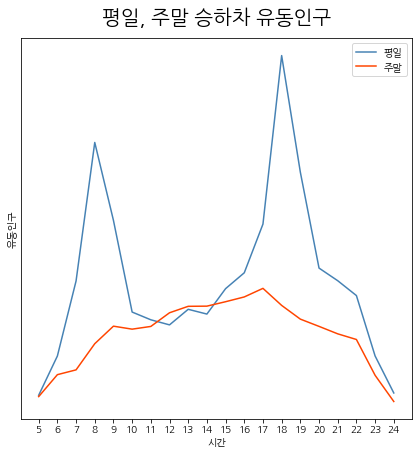

In [13]:
os.chdir(r'C:\Users\EonKim\Desktop\git_upload\khu\subway traffic\image\1011')
plt.figure(figsize = (7, 7))
plt.plot(week_board.iloc[3,:-2], color = 'SteelBlue', label  = '평일')
plt.plot(holi_board.iloc[3,:-2], color = 'OrangeRed', label = '주말')
plt.xticks(np.arange(5, 25))
plt.yticks([])
plt.xlabel('시간')
plt.ylabel('유동인구')
plt.title('평일, 주말 승하차 유동인구', size = 20, pad = 15)
plt.legend()
plt.savefig('평일, 주말 유동인구 비교.png')
plt.show()


In [14]:
week_alight.loc[line,['lat','lng']].to_csv('transfer_1.csv')
week_alight.loc[line2,['lat','lng']].to_csv('transfer_2.csv')
week_alight.loc[line3,['lat','lng']].to_csv('transfer_3.csv')
week_alight.loc[line4,['lat','lng']].to_csv('transfer_4.csv')

In [15]:
# week_board

center = [week_board.iloc[:,-2].mean(), week_board.iloc[:,-1].mean() ]

m = folium.Map(
    location = center, 
    zoom_start= 12
    )

folium.Choropleth(
    geo_data = seoul_geo,
    data = gu_subway,
    columns = ['name', 'number'],
    key_on = 'properties.name',
    fill_color = 'OrRd',
    fill_opacity = 0.5, 
    line_opacity = 0.4, 
    legend_name = 'number of station'
).add_to(m)

for lat, lng in np.array(week_board.loc[line2,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color= 'blue',
        fill = True,
        fill_opacity = 0.8,
        radius = 100,
        ).add_to(m)

for lat, lng in np.array(week_board.loc[line3,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color = 'green',
        fill = True,
        fill_opacity = 0.8,
        radius = 200,
        ).add_to(m)

for lat, lng in np.array(week_board.loc[line4,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color = 'red',
        weight = 3,
        fill_opacity = 0.8,
        fill = True,
        radius = 300,
        ).add_to(m)
m

In [16]:
total_line = line + line2 + line3 + line4
len(total_line)

238

In [17]:
# station_loc = week_board.loc[total_line, ['lat', 'lng']].copy()

In [20]:
# week_board

center = [week_board.iloc[:,-2].mean(), week_board.iloc[:,-1].mean() ]

m = folium.Map(
    location = center, 
    zoom_start= 12
    )

folium.Choropleth(
    geo_data = seoul_geo,
    data = gu_subway,
    columns = ['name', 'number'],
    key_on = 'properties.name',
    fill_color = 'OrRd',
    fill_opacity = 0.5, 
    line_opacity = 0.4, 
    legend_name = 'number of station'
).add_to(m)

for lat, lng in np.array(week_board.loc[line2,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color= 'blue',
        fill = True,
        fill_opacity = 0.8,
        radius = 100,
        ).add_to(m)

for lat, lng in np.array(week_board.loc[line3,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color = 'green',
        fill = True,
        fill_opacity = 0.8,
        radius = 200,
        ).add_to(m)

for lat, lng in np.array(week_board.loc[line4,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color = 'red',
        weight = 3,
        fill_opacity = 0.8,
        fill = True,
        radius = 300,
        ).add_to(m)
m

In [21]:
station_loc.iloc[173:,]

,lat,lng
가락시장,37.492522,127.118234
가산디지털단지,37.481072,126.882343
강남,37.497175,127.027926
강남구청,37.517186,127.041280
건대입구,37.540693,127.070230
...,...,...
홍대입구,37.557192,126.925381
공덕,37.544018,126.951592
김포공항,37.562434,126.801058
왕십리,37.561533,127.037732


In [22]:
station_loc.iloc[1,:].values.tolist()

[37.530341, 127.120508]

In [23]:
# week_alight

center = [week_alight.iloc[:,-2].mean(), week_alight.iloc[:,-1].mean() ]

m = folium.Map(
    location = center, 
    zoom_start= 12
    )

folium.Choropleth(
    geo_data = seoul_geo,
    # data = gu_subway,
    # columns = ['name', 'number'],
    # key_on = 'properties.name',
    fill_color = 'White',
    fill_opacity = 0.6, 
    line_opacity = 0.4, 
    legend_name = 'number of station'
).add_to(m)

icons = [folium.Icon(icon='subway', prefix = 'fa' , color = 'red') for _ in range(len(station_loc))]
pop = station_loc.index.tolist()
# for lat,lng in station_loc.iloc[173:,].values:
#     folium.Marker([lat, lng]).add_to(m)

for lat, lng in station_loc.iloc[[3, 10, 15],:].values:
    folium.Circle(
        location = [lat, lng], 
        color = 'blue',
        radius = 1500,
        fill = True,
        line_opcity = 0.3,
        fill_opacity = 0.3).add_to(m)

MarkerCluster(station_loc, icons = icons, popups = pop).add_to(m)
m

In [24]:
# holi_alight

center = [holi_alight.iloc[:,-2].mean(), holi_alight.iloc[:,-1].mean() ]

m = folium.Map(
    location = center, 
    zoom_start= 12
    )

folium.Choropleth(
    geo_data = seoul_geo,
    data = gu_subway,
    columns = ['name', 'number'],
    key_on = 'properties.name',
    fill_color = 'Blues',
    fill_opacity = 0.6, 
    line_opacity = 0.4, 
    legend_name = 'number of station'
).add_to(m)

for lat, lng in np.array(holi_alight.loc[line2,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color= 'blue',
        fill = True,
        fill_opacity = 1.0,
        radius = 100,
        ).add_to(m)

for lat, lng in np.array(holi_alight.loc[line3,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color = 'green',
        fill = True,
        fill_opacity = 1.0,
        radius = 200,
        ).add_to(m)

for lat, lng in np.array(holi_alight.loc[line4,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color = 'red',
        weight = 3,
        fill_opacity = 1.0,
        fill = True,
        radius = 300,
        ).add_to(m)
m

In [25]:
# holi_board

center = [holi_board.iloc[:,-2].mean(), holi_board.iloc[:,-1].mean() ]

m = folium.Map(
    location = center, 
    zoom_start= 11
    )

folium.Choropleth(
    geo_data = seoul_geo,
    data = gu_subway,
    columns = ['name', 'number'],
    key_on = 'properties.name',
    fill_color = 'Blues',
    fill_opacity = 0.6, 
    line_opacity = 0.4, 
    legend_name = 'number of station'
).add_to(m)

for lat, lng in np.array(holi_board.loc[line2,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color= 'blue',
        fill = True,
        fill_opacity = 1.0,
        radius = 100,
        ).add_to(m)

for lat, lng in np.array(holi_board.loc[line3,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color = 'green',
        fill = True,
        fill_opacity = 1.0,
        radius = 200,
        ).add_to(m)

for lat, lng in np.array(holi_board.loc[line4,['lat', 'lng']]):
    folium.Circle(
        location = [lat, lng],
        color = 'red',
        weight = 3,
        fill_opacity = 1.0,
        fill = True,
        radius = 300,
        ).add_to(m)
m

In [123]:
people = pd.concat([week_board.iloc[:,:-2].sum(axis = 1 ), week_board.iloc[:,-2:]], axis = 1)
people['station'] = people.index
people.columns = ['Passenger', 'lat', 'lng', 'station']

,Passenger,lat,lng,station
가락시장,47134.82,37.492522,127.118234,가락시장
가산디지털단지,158193.27,37.481072,126.882343,가산디지털단지
강남,200248.72,37.497175,127.027926,강남
강남구청,85538.56,37.517186,127.041280,강남구청
강동,111178.08,37.535804,127.132481,강동
...,...,...,...,...
홍제,21928.14,37.589066,126.943736,홍제
화곡,33225.93,37.541513,126.840461,화곡
화랑대,14435.10,37.620064,127.084689,화랑대
회현,34861.05,37.558514,126.978246,회현


In [127]:
gu_subway

,name,number
0,강남구,24
1,중구,14
2,송파구,18
3,마포구,15
4,강서구,17
5,영등포구,15
6,서초구,15
7,성동구,15
8,용산구,12
9,노원구,13


In [128]:
def visualization(target_station = ['강남'],zoom_start = 12, size = 1500, back_ground = 'OrRd', icon_color = 'red'):
    center = [ week_alight.iloc[:,-2].mean(), week_alight.iloc[:,-1].mean() ]

    m = folium.Map(
        location = center, 
        zoom_start= zoom_start
        )

    folium.Choropleth(
        geo_data = seoul_geo,
        data = gu_subway,
        columns = ['name', 'number'],
        key_on = 'properties.name',
        fill_color = back_ground,
        fill_opacity = 0.6, 
        line_opacity = 0.4, 
        legend_name = 'the number of station'
    ).add_to(m)

    icons = [folium.Icon(icon='subway', prefix = 'fa' , color = icon_color ) for _ in range(len(week_board))]
    pop = week_board.index.tolist()
    # for lat,lng in station_loc.iloc[173:,].values:
    #     folium.Marker([lat, lng]).add_to(m)

    target_icon = [folium.Icon(icon = 'subway', prefix = 'fa', color = 'red') for _ in range(len(target_station))]
    for lat, lng in week_board.loc[target_station,['lat','lng']].values:
        folium.Circle(
            location = [lat, lng], 
            color = 'blue',
            radius = size,
            fill = True,
            line_opcity = 0.3,
            fill_opacity = 0.3).add_to(m)
        folium.Marker([lat, lng], icon = folium.Icon(icon = 'subway', prefix = 'fa', color = 'red')).add_to(m)

    # MarkerCluster(week_board.loc[:,['lat', 'lng']], popups=pop).add_to(m)
    return m

In [129]:
visualization()